In [19]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split,cross_val_score
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, f1_score,accuracy_score,recall_score,precision_score,roc_auc_score, roc_curve,auc
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns 
import matplotlib.pyplot as plt

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


# Loading Data

In [20]:
data=pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")
data.head()

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


# Exploratory Data Analysis

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
memory usage: 4.

In [22]:
data.describe()

,age,balance,duration,campaign,pdays,previous
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,5441.781719,439.062789,5.108770,72.256051,11.826171
std,12.709352,16365.292065,769.096291,9.890153,160.942593,44.140259
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,98.000000,109.000000,1.000000,-1.000000,0.000000
50%,40.000000,549.000000,197.000000,2.000000,-1.000000,0.000000
75%,50.000000,2030.000000,380.000000,4.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


In [23]:
data.isna().sum()

last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64

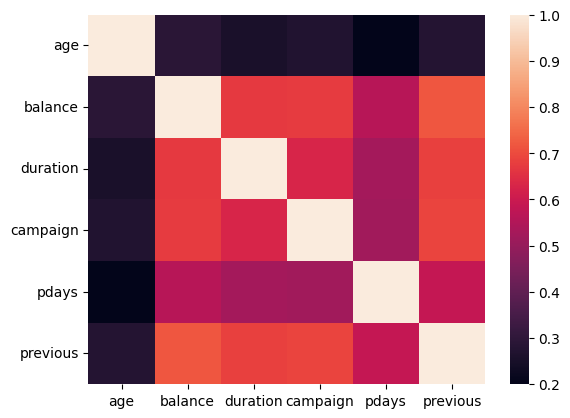

In [24]:
sns.heatmap(data.corr(numeric_only=True))
plt.show()

age column has very less correlation with other columns while other columns have correlation between 0.6 to 0.7 with other columns

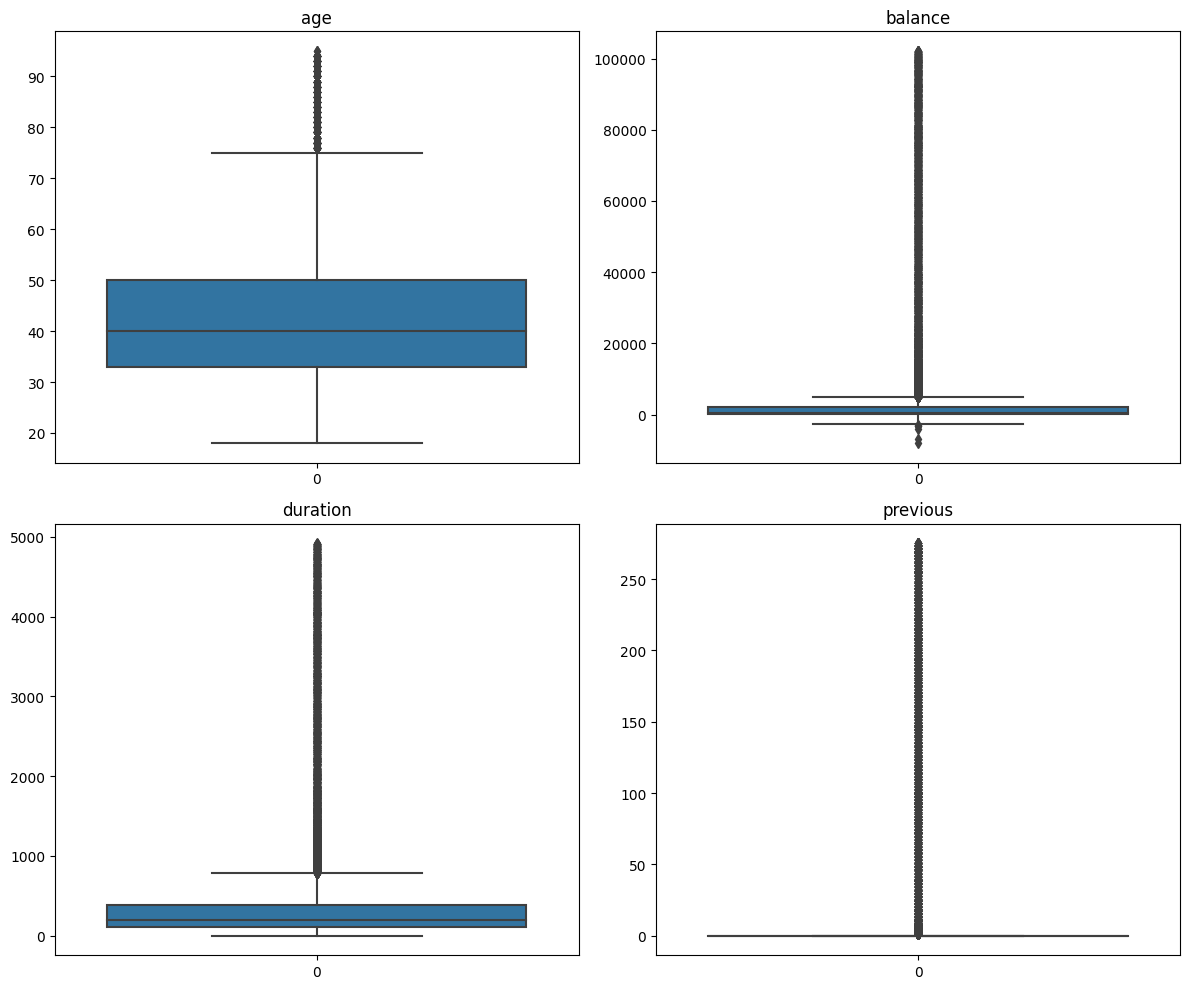

In [25]:
def boxplot_func(data, ax):
    sns.boxplot(data=data, ax=ax)
numerical_col = ["age", "balance", "duration", "previous"]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for idx, col in enumerate(numerical_col):
    j, k = divmod(idx, 2)
    boxplot_func(data[col], axes[j, k])
    axes[j, k].set_title(col)
plt.tight_layout()
plt.show()

Data needs to be cleaned as some columns have outliers so we must appropriaterly detect and replace outliers. Not all outliers should be replaced as some provide information such as previous, pdays columns need not to be cleaned

# Relation Between poutcome and Target

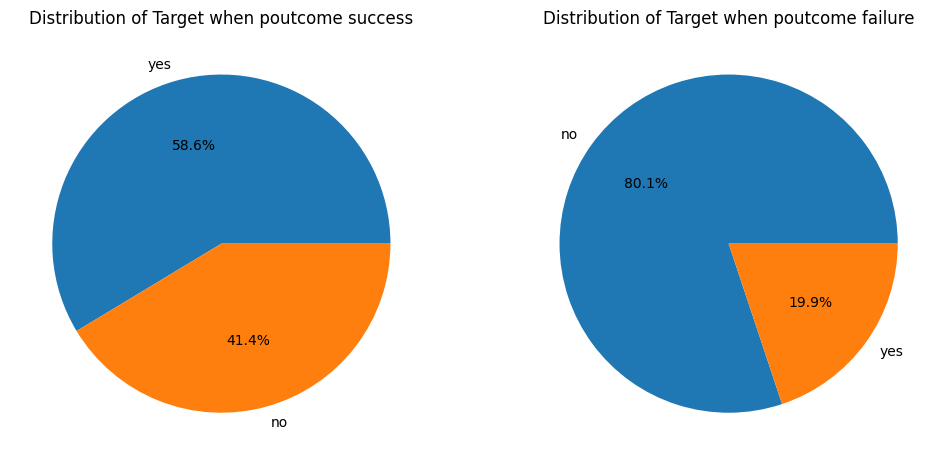

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 10))
suc=data[data["poutcome"]=="success"]["target"]
fail=data[data["poutcome"]=="failure"]["target"]
axes[0].pie(suc.value_counts().values, labels=suc.value_counts().index, autopct='%1.1f%%')
axes[0].set_title('Distribution of Target when poutcome success')
axes[1].pie(fail.value_counts().values, labels=fail.value_counts().index, autopct='%1.1f%%')
axes[1].set_title('Distribution of Target when poutcome failure')
plt.show()


If there is success in previous outcome then it is more likely that the client will subscribe to bank deposit.

# Didivding Training and Test Data

In [27]:
X_train,X_test,y_train,y_test=train_test_split(data.drop("target",axis=1),data["target"],test_size=0.2,random_state=20)

# Extracting Information from last date column

In [28]:
X_train["last contact date"]=pd.to_datetime(X_train['last contact date'])
X_train["day"]=X_train["last contact date"].dt.day_name()
X_train["date"]=X_train["last contact date"].dt.day
X_train["month"] = X_train["last contact date"].dt.month
X_train["year"] = X_train["last contact date"].dt.year
X_train.drop("last contact date",axis=1,inplace =True)

In [29]:
X_train.isna().sum()

age              0
job            176
marital          0
education     1142
default          0
balance          0
housing          0
loan             0
contact       8296
duration         0
campaign         0
pdays            0
previous         0
poutcome     23583
day              0
date             0
month            0
year             0
dtype: int64

# Function for outlier detection and replacing Outliers

In [30]:
def calculate_iqr_bounds(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound
    
def replace_outliers(df, column, lower_bound, upper_bound):
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
    return df

# Performing Anamoly Detection and replacing them 

In [31]:
# for balance column
lower_bound_train_balance, upper_bound_train_balance = calculate_iqr_bounds(X_train, 'balance')
X_train = replace_outliers(X_train, 'balance', lower_bound_train_balance, upper_bound_train_balance)
# for age column
lower_bound_train_age, upper_bound_train_age = calculate_iqr_bounds(X_train, 'age')
X_train = replace_outliers(X_train, 'age', lower_bound_train_age, upper_bound_train_age)
# for duration column
lower_bound_train_duration, upper_bound_train_duration = calculate_iqr_bounds(X_train, 'duration')
X_train = replace_outliers(X_train, 'duration', lower_bound_train_duration, upper_bound_train_duration)
# for campaign column
lower_bound_train_campaign, upper_bound_train_campaign = calculate_iqr_bounds(X_train, 'campaign')
X_train = replace_outliers(X_train, 'campaign', lower_bound_train_campaign, upper_bound_train_campaign)
# replacing missing value of poutcome with missing itself
X_train["poutcome"].replace(np.nan,"missing",inplace=True)

# Performing Initial Preprocessing and Data cleaning on test data

In [32]:
X_test["last contact date"]=pd.to_datetime(X_test['last contact date'])
X_test["day"]=X_test["last contact date"].dt.day_name()
X_test["date"]=X_test["last contact date"].dt.day
X_test["month"] = X_test["last contact date"].dt.month
X_test["year"] = X_test["last contact date"].dt.year
X_test.drop("last contact date",axis=1,inplace =True)
X_test["poutcome"].replace(np.nan,"missing",inplace=True)
X_test = replace_outliers(X_test, 'balance', lower_bound_train_balance, upper_bound_train_balance)
X_test = replace_outliers(X_test, 'age', lower_bound_train_age, upper_bound_train_age)
X_test = replace_outliers(X_test, 'duration', lower_bound_train_duration, upper_bound_train_duration)
X_test = replace_outliers(X_test, 'campaign', lower_bound_train_campaign, upper_bound_train_campaign)

In [33]:
num_col=["age","balance","duration","pdays","previous","date","duration","month","year"]
cat_col=["job","marital","education","default","housing","loan","contact","day","poutcome"]

# Model 1

In [34]:
numpipe=Pipeline(
    [
        ("impute",SimpleImputer()),
        # ("scale",StandardScaler())
    ]
)
catpipe=Pipeline(
    [
        ("impute",SimpleImputer(strategy="most_frequent")),
        ("encode",OneHotEncoder()),
    ]
)
ct=ColumnTransformer(
    [
        ("num",numpipe,num_col),
        ("cat",catpipe,cat_col)
    ],remainder="drop"
)
pipe1=Pipeline([("ct",ct),
               ("scale",StandardScaler(with_mean=False))
              ])
sample_weights = np.where(y_train == "yes", 20, 8)
X_transformed=pipe1.fit_transform(X_train,y_train)
clf1=GradientBoostingClassifier(max_depth=5,max_features= 0.6, min_samples_leaf= 2, min_samples_split=2,n_estimators=100,random_state=20)
clf1.fit(X_transformed,y_train,sample_weight=sample_weights)

GradientBoostingClassifier(max_depth=5, max_features=0.6, min_samples_leaf=2,
                           random_state=20)

# Performance on test set

In [35]:
X_test_transformed1=pipe1.transform(X_test)
y_pred1=clf1.predict(X_test_transformed1)
print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

          no       0.96      0.88      0.92      6672
         yes       0.53      0.77      0.63      1171

    accuracy                           0.86      7843
   macro avg       0.74      0.83      0.77      7843
weighted avg       0.89      0.86      0.87      7843



# Loading Test Data and Submitting to Competition


In [36]:
X_com_test=pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")
X_com_test["last contact date"]=pd.to_datetime(X_com_test['last contact date'])
X_com_test["day"]=X_com_test["last contact date"].dt.day_name()
X_com_test["date"]=X_com_test["last contact date"].dt.day
X_com_test["month"] = X_com_test["last contact date"].dt.month
X_com_test["year"] = X_com_test["last contact date"].dt.year
X_com_test.drop("last contact date",axis=1,inplace =True)
X_com_test = replace_outliers(X_com_test, 'balance', lower_bound_train_balance, upper_bound_train_balance)
X_com_test = replace_outliers(X_com_test, 'age', lower_bound_train_age, upper_bound_train_age)
X_com_test = replace_outliers(X_com_test, 'duration', lower_bound_train_duration, upper_bound_train_duration)
X_com_test = replace_outliers(X_com_test, 'campaign', lower_bound_train_campaign, upper_bound_train_campaign)
X_com_test_transformed=pipe1.transform(X_com_test)
y_com_pred=clf1.predict(X_com_test_transformed)
submission=pd.DataFrame({
    "id":np.arange(0,10000),
    "target":y_com_pred
    })
submission.to_csv("submission.csv",index=False)

# Submission to the Competition

# Model 2

In [37]:
# num_col=["age","duration","previous"]
num_col=["age","balance","duration","pdays","previous","date","duration"]
cat_col=["job","education","housing","loan","day","poutcome","contact"]
X_train.replace(np.nan,"missing",inplace=True)
numpipe=Pipeline(
    [
        ("impute",SimpleImputer())
    ]
)
catpipe=Pipeline(
    [
        ("impute",SimpleImputer(strategy="most_frequent")),
        ("encode",OneHotEncoder())
    ]
)
ct=ColumnTransformer(
    [
        ("num",numpipe,num_col),
        ("cat",catpipe,cat_col)
    ],remainder="drop"
)
pipe2=Pipeline([("ct",ct),
                ("rfe",RFE(estimator=GradientBoostingClassifier(),n_features_to_select=15))
              ])
X_transformed=pipe2.fit_transform(X_train,y_train)
clf2=DecisionTreeClassifier(criterion="gini",max_depth=10, min_samples_leaf=5, min_samples_split= 20,class_weight={"no":8,"yes":12},max_leaf_nodes=20,max_features=None)
clf2.fit(X_transformed,y_train)
X_test_transformed2=pipe2.transform(X_test)
y_pred2=clf2.predict(X_test_transformed2)
print(classification_report(y_test,y_pred2))


              precision    recall  f1-score   support

          no       0.93      0.90      0.92      6672
         yes       0.53      0.64      0.58      1171

    accuracy                           0.86      7843
   macro avg       0.73      0.77      0.75      7843
weighted avg       0.87      0.86      0.87      7843



In [39]:
# param_grid={"max_depth":[5,10,None],
#            "criterion":["gini","entropy"],
#             "class_weight":["balanced",{"yes":3,"no":8},{"yes":8,"no":12}],
#             "min_samples_leaf":[1,2,5],
#             "min_samples_split":[None,10,20]
#            }
# grid=GridSearchCV(DecisionTreeClassifier(random_state=20),param_grid=param_grid,cv=4,scoring="f1_macro")
# grid.fit(pipe2.transform(X_train),y_train)
# print(classification_report(y_test,clf2.predict(pipe2.transform(X_test))))

In [40]:
# grid.best_params_

# Model 3

In [41]:
# num_col=["age","duration","previous"]
num_col=["age","balance","duration","pdays","previous","date","duration"]
cat_col=["job","education","housing","loan","day","poutcome","contact"]
X_train.replace(np.nan,"missing",inplace=True)
numpipe=Pipeline(
    [
        ("impute",SimpleImputer())
    ]
)
catpipe=Pipeline(
    [
        ("impute",SimpleImputer(strategy="most_frequent")),
        ("encode",OneHotEncoder())
    ]
)
ct=ColumnTransformer(
    [
        ("num",numpipe,num_col),
        ("cat",catpipe,cat_col)
    ],remainder="drop"
)
pipe3=Pipeline([("ct",ct),
                ("rfe",RFE(estimator=DecisionTreeClassifier(),n_features_to_select=13)),
                ("scale",StandardScaler(with_mean=False))
              ])
X_transformed3=pipe3.fit_transform(X_train,y_train)
clf3=AdaBoostClassifier(estimator=LogisticRegression(C=2,class_weight={"yes":4,"no":18},random_state=20,max_iter=500),random_state=20,n_estimators=100,learning_rate=2,algorithm="SAMME.R")
clf3.fit(X_transformed3,y_train)
X_test_transformed3=pipe3.transform(X_test)
y_pred3=clf3.predict(X_test_transformed3)
print(classification_report(y_test,y_pred3))

              precision    recall  f1-score   support

          no       0.94      0.89      0.91      6672
         yes       0.52      0.65      0.58      1171

    accuracy                           0.86      7843
   macro avg       0.73      0.77      0.75      7843
weighted avg       0.87      0.86      0.86      7843



# Comparison between models between 

In [42]:
clf1_acc=f1_score(y_test,y_pred1,pos_label="yes",average="macro")
clf2_acc=f1_score(y_test,y_pred2,pos_label="yes",average="macro")
clf3_acc=f1_score(y_test,y_pred3,pos_label="yes",average="macro")

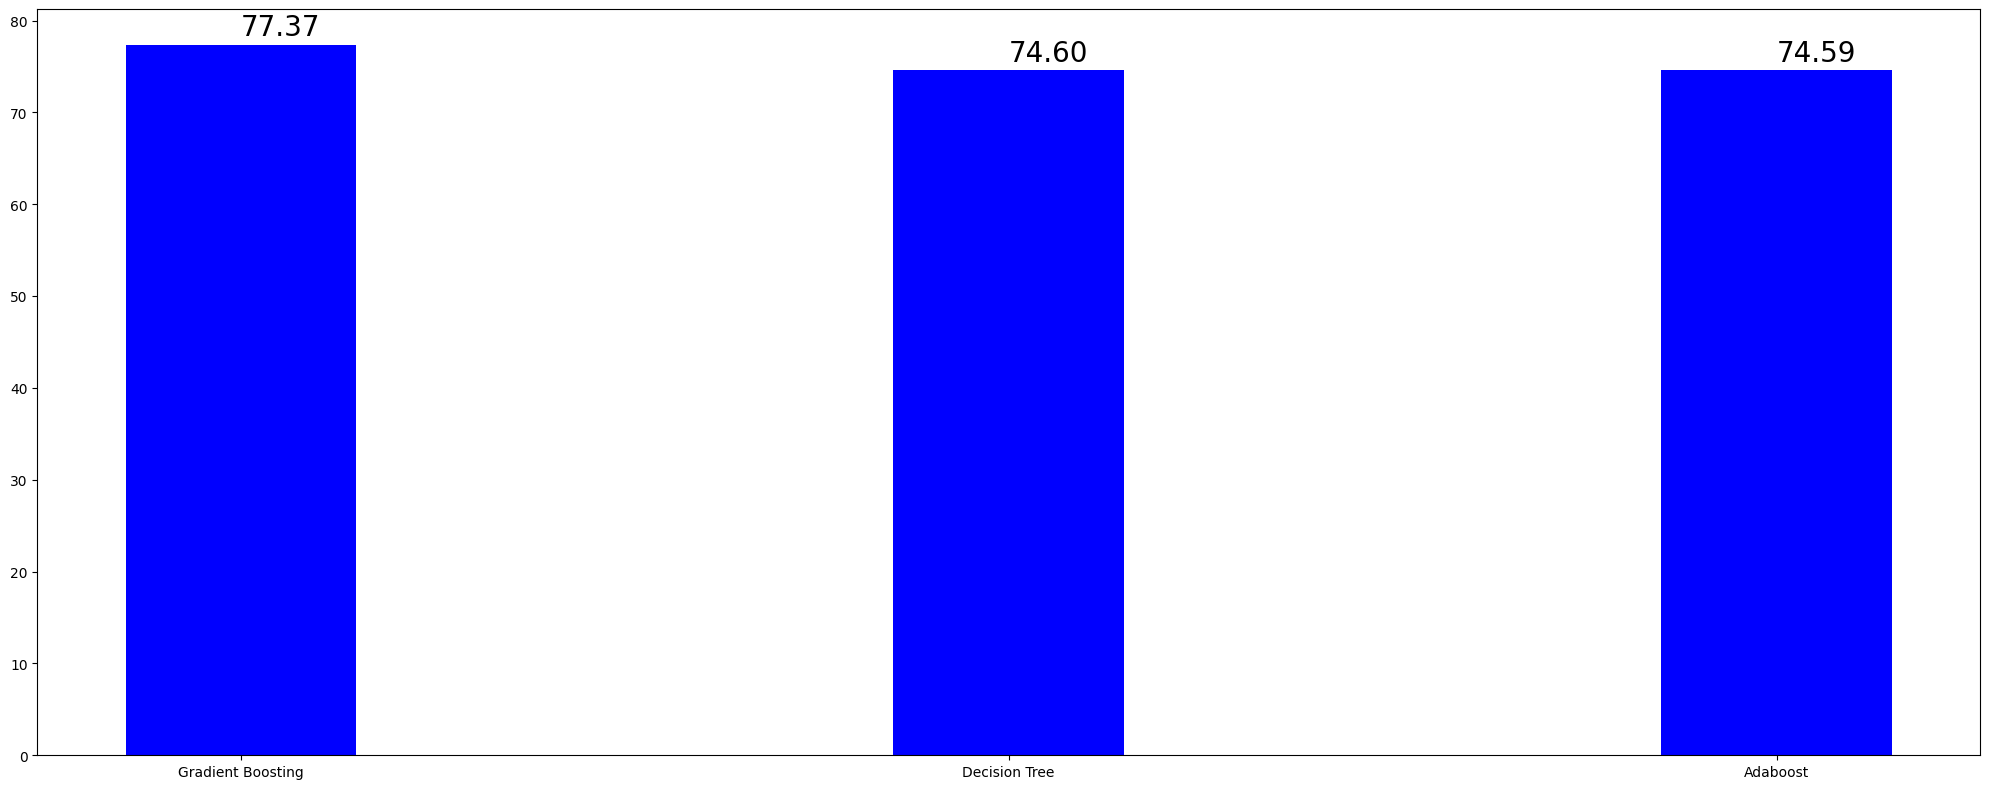

In [43]:
menMeans = np.array([clf1_acc,clf2_acc,clf3_acc])*100
ind = ['Gradient Boosting','Decision Tree','Adaboost']
fig, ax = plt.subplots(figsize = (20,8))
ax.bar(ind,menMeans,width=0.3,color ='blue')
for index,data in enumerate(menMeans):
    plt.text(x=index , y =data+1 , s="{:.2f}".format(data) , fontdict=dict(fontsize=20))
plt.tight_layout()
plt.show()

In [ ]:
def val_score(clf,X,y):
    cross_val_results = cross_val_score(clf, X, y, cv=4)
    print('Validation for different Classifier Model')
    print(f'Cross-Validation Results: {cross_val_results}')
    print(f'Mean F1_score: {cross_val_results.mean()}')
    print(f'Number of CV Scores used in Average: {len(cross_val_results)}')
print("For clf1")
val_score(clf1,pipe1.transform(X_test),y_test)
print("For clf2")
val_score(clf2,pipe2.transform(X_test),y_test)
print("For clf3")
val_score(clf3,pipe3.transform(X_test),y_test)

For clf1
Validation for different Classifier Model
Cross-Validation Results: [0.86588475 0.86282509 0.85976543 0.86581633]
Mean F1_score: 0.8635728985627906
Number of CV Scores used in Average: 4
For clf2
Validation for different Classifier Model
Cross-Validation Results: [0.86027537 0.85415604 0.85466599 0.85408163]
Mean F1_score: 0.855794757984785
Number of CV Scores used in Average: 4
For clf3


In [ ]:
y_test_transform=y_test.copy()
y_pred1_transform=y_pred1.copy()
y_pred2_transform=y_pred2.copy()
y_pred3_transform=y_pred3.copy()
y_test_transform = np.where(y_test == "yes", 1, 0)
y_pred1_transform = np.where(y_pred1 == "yes", 1, 0)
y_pred2_transform = np.where(y_pred2 == "yes", 1, 0)
y_pred3_transform = np.where(y_pred3 == "yes", 1, 0)

In [ ]:
# roc score for clf1
roc1=roc_auc_score(y_test_transform,y_pred1_transform)
# roc score for clf2
roc2=roc_auc_score(y_test_transform,y_pred2_transform)
# roc score for clf3
roc3=roc_auc_score(y_test_transform,y_pred3_transform)
menMeans = np.array([roc1,roc2,roc3])*100
ind = ['Gradient Boosting','Decision Tree','Adaboost']
fig, ax = plt.subplots(figsize = (20,8))
ax.bar(ind,menMeans,width=0.3,color ='blue')
for index,data in enumerate(menMeans):
    plt.text(x=index , y =data+1 , s="{:.2f}".format(data) , fontdict=dict(fontsize=20))
plt.tight_layout()
plt.show()

from roc_auc_score,accuracy score and f1_score we can interpret that our model 1 is best among three. 